ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Book-Publisher         object
dtype: object
User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object
User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64
User-ID             0
User-City          61
User-State          0
User-Country        2
User-Age        18952
dtype: int64
User-ID             0
User-City          61
User-State          0
User-Country        0
User-Age        18952
dtype: int64
User-ID without duplicative vlaues
no duplicative values

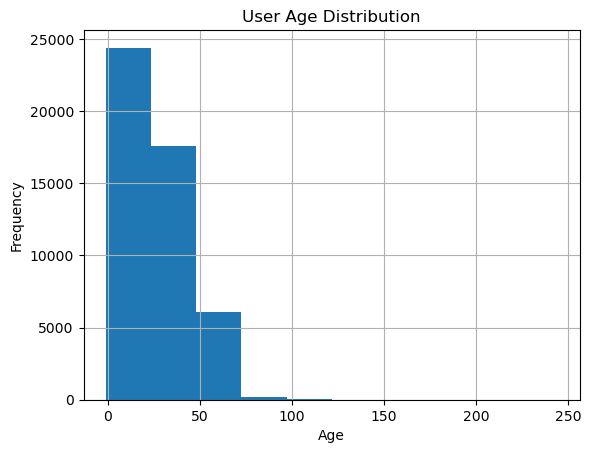

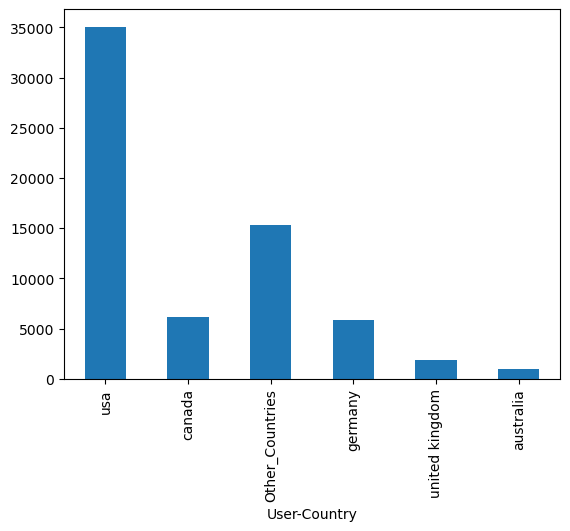

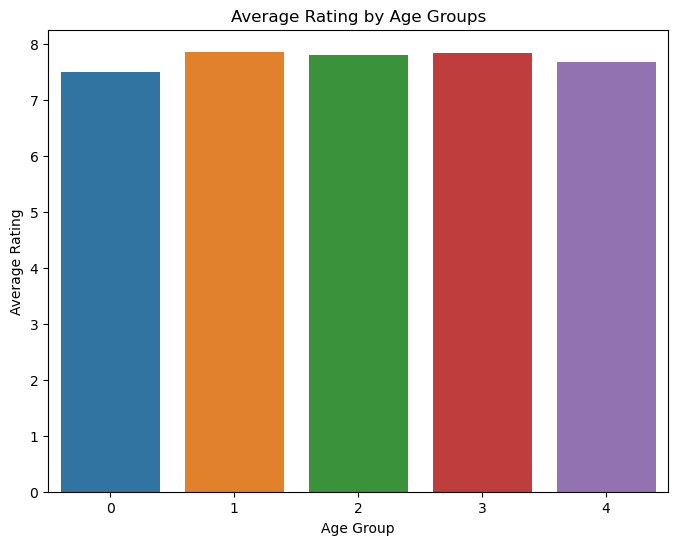

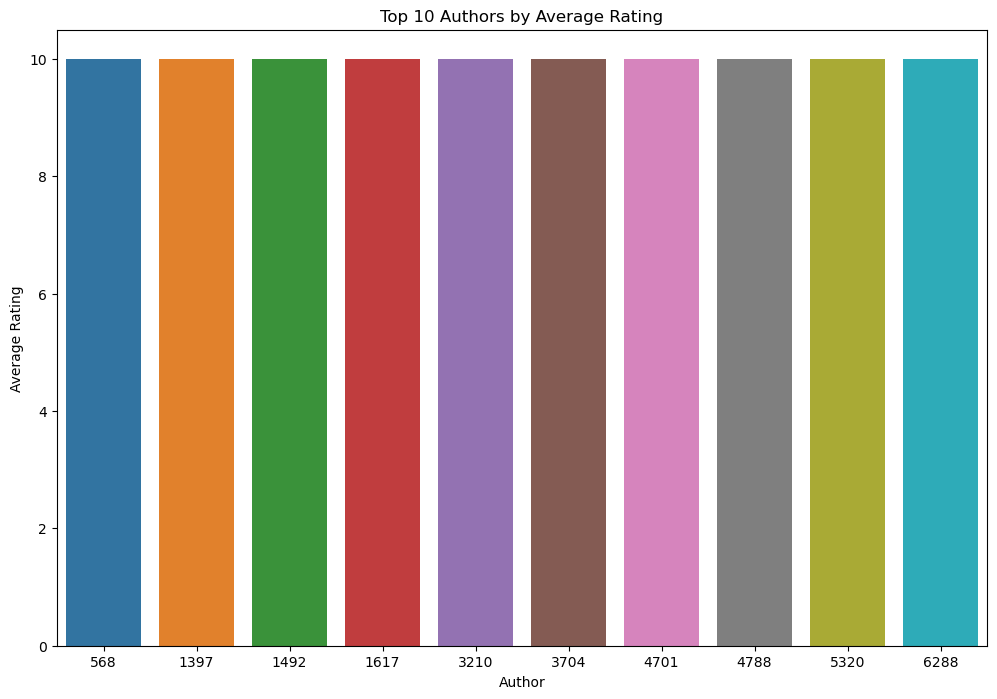

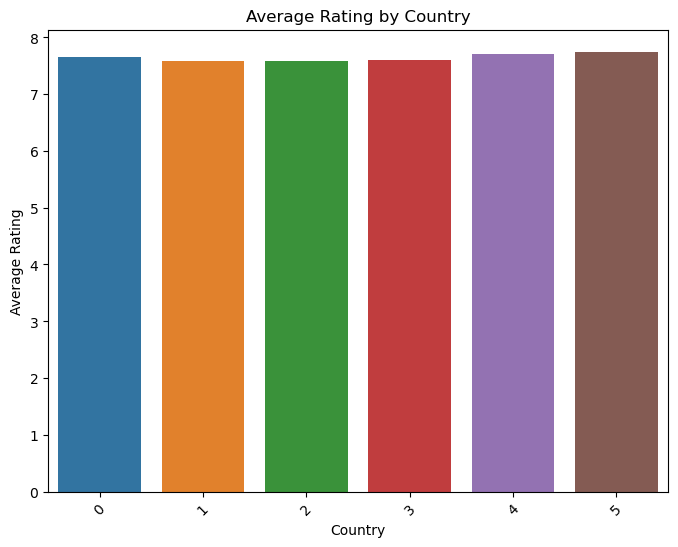

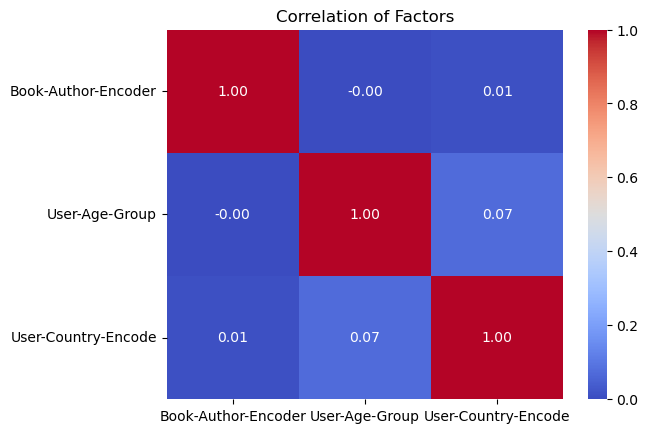

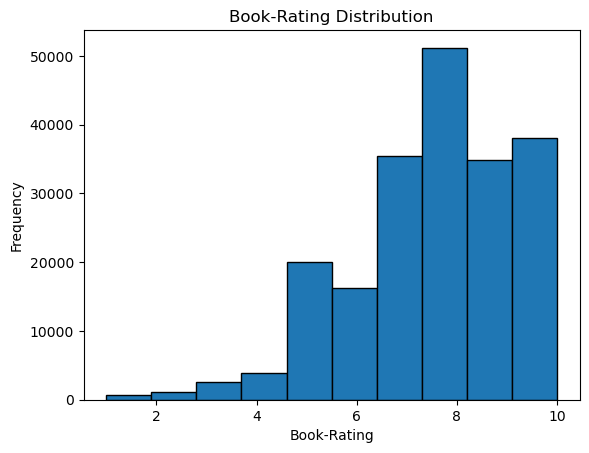

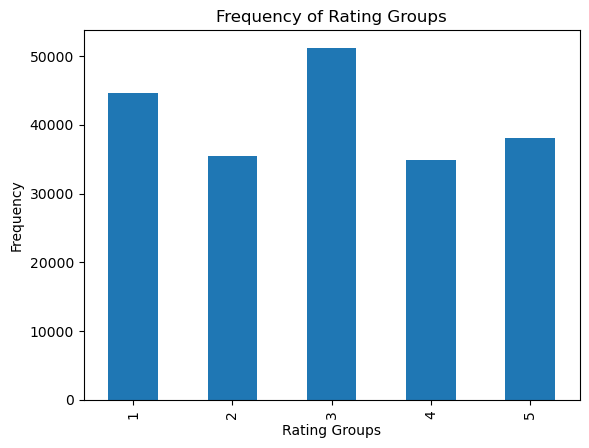

Decision Tree classifier Metrics:
Accuracy:0.2405
F1-score:0.2310
Classification:
              precision    recall  f1-score   support

           1       0.26      0.35      0.30       877
           2       0.16      0.17      0.17       678
           3       0.27      0.28      0.27       983
           4       0.20      0.14      0.16       684
           5       0.30      0.23      0.26       778

    accuracy                           0.24      4000
   macro avg       0.24      0.23      0.23      4000
weighted avg       0.24      0.24      0.24      4000

KNN Tree classifier Metrics:
Accuracy:0.2409
F1-score:0.2254
Classification:
              precision    recall  f1-score   support

           1       0.25      0.34      0.29       877
           2       0.17      0.17      0.17       678
           3       0.25      0.29      0.27       983
           4       0.22      0.13      0.16       684
           5       0.31      0.21      0.25       778

    accuracy              

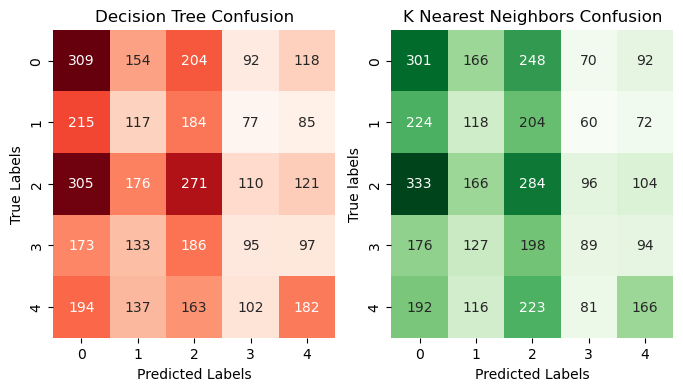

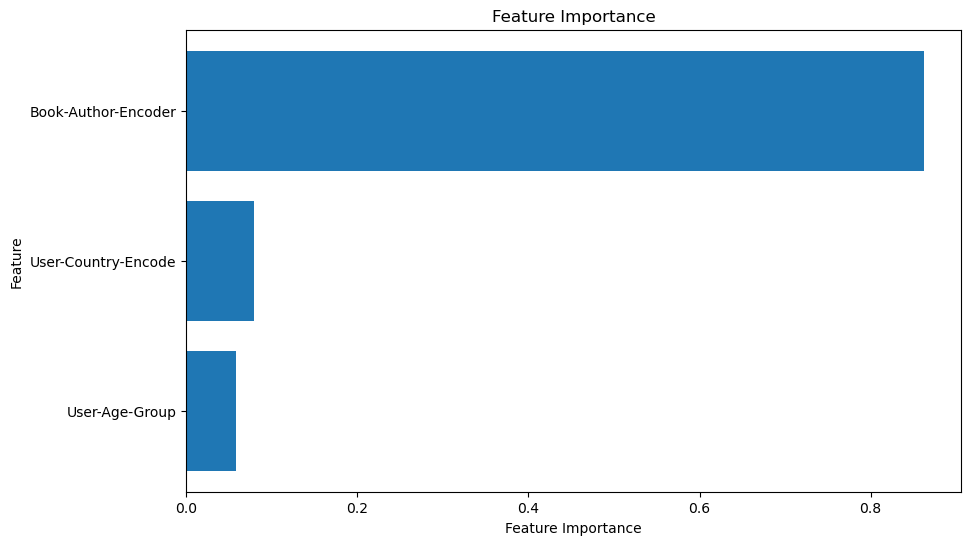

In [4]:
# import those necessary python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import plot_tree


# read the three csv data to dataframes and roughly review the data
books = pd.read_csv("BX-Books.csv")
ratings = pd.read_csv("BX-Ratings.csv")
users = pd.read_csv("BX-Users.csv")
print(books.dtypes)
books.head()
print(ratings.dtypes)
ratings.head()
print(users.dtypes)
users.head()

# Data pre-processing 
# 1. In case there are blank string " " values in the column User-Country or User-Age, we replace them with Nan first,
# so we can process them with other missing values.
# also use .strip() to remove the unnecessary blank space at the beginning and the end of the string
users["User-Country"] = users["User-Country"].str.strip()  
users["User-Country"].replace('', np.nan, inplace=True)  
users["User-Age"] = users["User-Age"].str.strip() 
users["User-Age"].replace('', np.nan, inplace=True)

#2. check and count missing values in the three different data sets
book_missing = books.isna().sum()
print(book_missing)

ratings_missing = ratings.isna().sum()
print(ratings_missing)

users_missing = users.isna().sum()
print(users_missing)

# 3. handling format error
# in User-Country replacing double qutaion mark """ to "", which means to delete the double quatation mark after the string. 
users['User-Country'] = users['User-Country'].str.strip('"').str.lower()
users["User-Country"].head()
# in User-Age replacing double qutaion mark """ to "", which means to delete the double quatation mark after the string. 
users['User-Age'] = users['User-Age'].str.strip('"')
users["User-Age"].head()

# 4. handling missing values
# filling missing values of Country by using the data with the same state.
# First use the data that has the country values
missing_countries = users[users['User-Country'].isnull()]
existing_data = users.dropna(subset=['User-Country'])
# create a mapping of state and country that associates each state with a country
state_country_map = existing_data.groupby('User-State')['User-Country'].first().to_dict()
## filling the missing values of Country using the mapping with existing country values
for index, row in missing_countries.iterrows():
    state=row['User-State']
    user_duplicates = users['User-ID'].duplicated()
    if state in state_country_map:
        users.at[index,'User-Country'] = state_country_map[state]
users_missing = users.isna().sum()
print(users_missing)

# Drop the left rows that have missing values in the columns Country and State, which we can not fill with the country values
#that have shown in 
users = users.dropna(subset=['User-Country'])
#Check the missing values again of all the columns in users
users_missing = users.isna().sum()
print(users_missing)


# Check if duplicative values exist in User-ID in Users dataframe.
user_duplicates = users['User-ID'].duplicated()
if user_duplicates.any():
    print("duplication exists in User-ID")
else:
    print("User-ID without duplicative vlaues")


# Check if duplicative ISBN values exist in books dataframe.
books_duplicates = books['ISBN'].duplicated()
if books_duplicates.any():
    print("duplicative values exists in books")
else:
    print("no duplicative values in books")

# Change User-Age type
users['User-Age'] = users['User-Age'].fillna('-1').astype(int)
users.dtypes

# Visualize the distribution of the original User-Age data using histogram
users["User-Age"].hist(bins=10)

plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# change noisy data, some users may not reveal real age
users["User-Age"] = users["User-Age"].clip(upper=100)
#the continuous features discretisazion 
bins = [-2,0,24,44,59,100]
labels = [0,1,2,3,4]
# Bin for User-Age values
users["User-Age-Group"] = pd.cut(users["User-Age"], bins = bins, labels = labels, include_lowest = True)
# Plot histogram for the distribution of User-Age groups 
users["User-Age-Group"].value_counts().sort_index().plot(kind = 'bar')

# remove city because we do not want to analyze this feature.
users.drop(['User-City'], axis = 1, inplace = True)
 
# remove the countries with less than 900 occurrences.
country_remove_index = users["User-Country"].value_counts()[users["User-Country"].value_counts() < 900].index
users.loc[users["User-Country"].isin(country_remove_index), "User-Country"] = "Other_Countries"
users["User-Country"].value_counts().plot(kind = 'bar')

# encode data of User-Country and also Book-Author
label_encoder = LabelEncoder()
users['User-Country-Encode'] = label_encoder.fit_transform(users['User-Country'])
label=LabelEncoder()
books['Book-Author-Encoder']=label.fit_transform(books['Book-Author'])


# create new users and books
users_new = users[["User-ID","User-Age-Group", "User-Country-Encode"]]
books_new = books[["Book-Author", "Book-Author-Encoder", "ISBN"]]

# Merge the three data sets: users, books and ratings
merged_data = pd.merge(ratings,books_new,on = 'ISBN',how = 'inner')
merged_data_user = pd.merge(merged_data,users_new,on = 'User-ID',how = 'inner')
merged_data = merged_data_user.drop(columns = ["User-ID","ISBN", "Book-Author"])

#Compare the variation of book rating among different sub-groups for the features User-Age, User-Country and Book-Author

# Average rating by age groups
age_group_avg_rating = merged_data.groupby('User-Age-Group')['Book-Rating'].mean().sort_values(ascending=False)
# Visualization with bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=age_group_avg_rating.index, y=age_group_avg_rating.values)
plt.title('Average Rating by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.show()

# Average rating by book authors
author_avg_rating = merged_data.groupby('Book-Author-Encoder')['Book-Rating'].mean().sort_values(ascending=False)
# Top 10 authors with average visualisation ratings
top_authors = author_avg_rating.head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_authors.index, y=top_authors.values)
plt.title('Top 10 Authors by Average Rating')
plt.xlabel('Author')
plt.ylabel('Average Rating')
plt.show()

#Average rating by country
country_avg_rating = merged_data.groupby('User-Country-Encode')['Book-Rating'].mean().sort_values(ascending=False)
# Visualization with bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=country_avg_rating.index, y=country_avg_rating.values)
plt.title('Average Rating by Country')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)  # If the country name is too long, rotate the label
plt.show()

#Now, we can just leave the original book author information and use the encoded Book-Author for taining the ML models
merged_data = merged_data_user.drop(columns=["Book-Author","User-ID","ISBN"])


# according to the correlation values, we can see all the three features are independent.
data_without_rating = merged_data.drop(columns = ['Book-Rating'])
correlation_map = data_without_rating.corr()
plt.figure()
sns.heatmap(correlation_map, annot=True,cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Factors')
plt.show()

# book rating distribution
plt.hist(merged_data['Book-Rating'], bins = 10, edgecolor = 'black')
plt.title('Book-Rating Distribution')
plt.xlabel('Book-Rating')
plt.ylabel('Frequency')
plt.show()

#Divide the ratings into 6 groups
merged_data['Rating-Groups'] = pd.cut(merged_data['Book-Rating'],
    bins = [0,6,7,8,9,10],
    labels = [1,2,3,4,5], right = True)
    
#Present the distribution of each rating group with histogram 
rating_counts = merged_data['Rating-Groups'].value_counts().sort_index()
rating_counts.plot(kind='bar')
plt.title('Frequency of Rating Groups')
plt.ylabel('Frequency')
plt.xlabel('Rating Groups')
plt.show()

# Decision Tree

# extract sample data
sub_data = merged_data.sample(n = 20000, random_state = 20240504)

#set the features and labels of the model
x = sub_data.drop(columns = ['Book-Rating','Rating-Groups'])
y = sub_data['Rating-Groups']
# split data into the training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 20240504)

# Decision Tree Classifier
DT_classifier = DecisionTreeClassifier(random_state = 20240504) 

# Training the Decision Tree Classifier, and use the model to predict data in the testing set
DT_classifier.fit(x_train, y_train)
DT_predict = DT_classifier.predict(x_test)


# Specify the metrics used to evaluate model performance
DT_accuracy = cross_val_score(DT_classifier, x, y, cv = 5,scoring = 'accuracy')
DT_f1 = cross_val_score(DT_classifier, x, y, cv = 5, scoring = 'f1_macro')


# Show the confusion matrix 
DT_confusion = confusion_matrix(y_test,DT_predict)
DT_classification = classification_report(y_test,DT_predict)

# knn classifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 10)

# Fit the training dataset
KNN_classifier.fit(x_train, y_train)
KNN_predict = KNN_classifier.predict(x_test)

# Specify the metrics used to evaluate model performance
KNN_accuracy = cross_val_score(KNN_classifier, x, y, cv = 5, scoring = 'accuracy')
KNN_f1 = cross_val_score(KNN_classifier, x, y, cv = 5, scoring = 'f1_macro')

# Show the confusion matrix 
KNN_confusion = confusion_matrix(y_test, KNN_predict)
KNN_classification = classification_report(y_test, KNN_predict)

# Print classification results of both DT and KNN models
print('Decision Tree classifier Metrics:')
print(f'Accuracy:{np.mean(DT_accuracy):.4f}')
print(f'F1-score:{np.mean(DT_f1):.4f}')
print('Classification:')
print(DT_classification)

print('KNN Tree classifier Metrics:')
print(f'Accuracy:{np.mean(KNN_accuracy):.4f}')
print(f'F1-score:{np.mean(KNN_f1):.4f}')
print('Classification:')
print(KNN_classification)

# Visualize the confusion matrix of both the two ML models
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.heatmap(DT_confusion, annot=True, fmt="d", cmap="Reds",cbar=False)
plt.title("Decision Tree Confusion")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.subplot(1,2,2)
sns.heatmap(KNN_confusion, annot=True, fmt="d", cmap="Greens",cbar=False)
plt.title("K Nearest Neighbors Confusion")
plt.xlabel("Predicted Labels")
plt.ylabel("True labels")

plt.show()

# show feature importance
DT_classifier.fit(x,y)
feature_importances = DT_classifier.feature_importances_
feature_names = x.columns
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)),feature_importances_[sorted_idx])
plt.yticks(range(len(sorted_idx)),[feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


